# Fake Job Postings

Link to the source of data: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction <br>
Sorry for my English please /\

## Data

Features list (`Variable`: Definition):

- `job_id`: Unique Job ID<br>
- `title`: The title of the job ad entry<br>
- `location`: Geographical location of the job ad<br>
- `department`: Corporate department (e.g. sales)<br>
- `salary_range`: Indicative salary range (e.g. $50,000-60,000)<br>
- `company_profile`: A brief company description<br>
- `description`: The details description of the job ad<br>
- `requirements`: Enlisted requirements for the job opening<br>
- `benefits`: Enlisted offered benefits by the employer<br>
- `telecommuting`: True for telecommuting positions<br>
- `has_company_logo`: True if company logo is present<br>
- `has_questions`: True if screening questions are present<br>
- `employment_type`: Full-type, Part-time, Contract, etc<br>
- `required_experience`: Executive, Entry level, Intern, etc<br>
- `required_education`: Doctorate, Master’s Degree, Bachelor, etc<br>
- `industry`: Automotive, IT, Health care, Real estate, etc<br>
- `function`: Consulting, Engineering, Research, Sales etc<br>
- `fraudulent`: target - Classification attribute<br>

__fake_job_postings.csv__ - the dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import string
from tqdm import tqdm

import numpy as np
import scipy as sp
from scipy import stats
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

## First look

In [2]:
data = pd.read_csv('fake_job_postings.csv')
data.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

There are many NA-values in the table and there are features that have to be preprocessed for further usage. Let's save names of text features and of features which need to be worked on:

In [4]:
text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']

And drop `job_id`, it's useless.

In [5]:
data.drop('job_id', axis=1, inplace=True)

## Feature preparation

### Text features

Features that describe textual components of job post:

In [6]:
data[text_features].head()

,title,company_profile,description,requirements,benefits
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


Let's fill NA-values with a string-marker that will indicate the absence of a `title`, `description` and so on:

In [7]:
data[text_features].fillna('ValueWasntSpecified', inplace=True)
for feature_name in text_features:
    data[feature_name].fillna('ValueWasntSpecified', inplace=True)

Now we have to clean our texts from punctuation marks and stop-words, and apply stemming:

In [8]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [9]:
nltk_supported_languages = ['hungarian', 'swedish', 'kazakh', 'norwegian',
                            'finnish', 'arabic', 'indonesian', 'portuguese',
                            'turkish', 'azerbaijani', 'slovene', 'spanish',
                            'danish', 'nepali', 'romanian', 'greek', 'dutch',
                            'tajik', 'german', 'english', 'russian',
                            'french', 'italian']

In [10]:
# loading stop words list
stop_words = set(stopwords.words(nltk_supported_languages))

In [11]:
# initialising stemmer
porter = PorterStemmer()

In [12]:
def preprocess_texts(texts):
    '''Returns a list of clean and word-stemmed strings.'''
    preprocessed_texts = []
    for text in tqdm(texts):
        # punctuation marks cleaning
        text = ''.join([sym.lower() for sym in text if sym.isalpha() or sym == ' '])
        
        # tokenization
        tokenized_text = word_tokenize(text)
        
        # stop words cleaning
        tokenized_text_wout_sw = [word for word in tokenized_text if word not in stop_words]
        
        # stemming
        tokenized_text_wout_sw_stem = [porter.stem(word) for word in tokenized_text_wout_sw]
        
        # saving result
        preprocessed_texts += [' '.join(tokenized_text_wout_sw_stem)]
    
    return preprocessed_texts

In [13]:
%%time
for feature_name in text_features:
    data[feature_name] = preprocess_texts(data[feature_name])

data[text_features].head()

100%|██████████| 17880/17880 [00:16<00:00, 1095.93it/s]

CPU times: user 3min 3s, sys: 1.48 s, total: 3min 5s
Wall time: 3min 6s


,title,company_profile,description,requirements,benefits
0,market intern,food weve creat groundbreak awardwin cook site...,food fastgrow jame beard awardwin onlin food c...,experi content manag system major plu blog cou...,valuewasntspecifi
1,custom servic cloud video product,second world cloud video product servic second...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...
2,commiss machineri assist cma,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,valuewasntspecifi
3,account execut washington dc,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educationbachelor master gi busi administr rel...,cultur anyth corporatew collabor creativ envir...
4,bill review manag,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer


Done! Now move on to complex features.

### Complex features

#### `location`

The main structure of `location`'s values is `Country, State, City`:

In [14]:
location = data['location'].copy()
location.head(15)

0          US, NY, New York
1            NZ, , Auckland
2             US, IA, Wever
3        US, DC, Washington
4        US, FL, Fort Worth
5                  US, MD, 
6            DE, BE, Berlin
7     US, CA, San Francisco
8         US, FL, Pensacola
9           US, AZ, Phoenix
10      US, NJ, Jersey City
11          GB, LND, London
12         US, CT, Stamford
13          US, FL, Orlando
14          AU, NSW, Sydney
Name: location, dtype: object

Let's divide and extract these elements. We will use them as a categorical features in the future.

In [15]:
location_splitted = list(location.str.split(', ').values)
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', '', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', ''],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

Filling in missing values:

In [16]:
for loc_ind, loc in enumerate(location_splitted):
    if loc is np.nan:
        location_splitted[loc_ind] = ['ValueWasntSpecified'] * 3
    else:
        for el_ind, el in enumerate(loc):
            if el == '':
                loc[el_ind] = 'ValueWasntSpecified'

In [17]:
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', 'ValueWasntSpecified', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', 'ValueWasntSpecified'],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

But there are some troubles:

In [18]:
any([len(loc) > 3 for loc in location_splitted])

True

In [19]:
any([len(loc) < 3 for loc in location_splitted])

True

Not all values of `location` were described in 3 elements. Let's look at unusual values:

In [20]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        print(loc_ind, loc)

16 ['IL', 'ValueWasntSpecified', 'Tel Aviv', 'Israel']
69 ['US', 'CA', 'Menlo Park', 'CA']
98 ['US', 'ValueWasntSpecified', 'Stocton', 'CA']
215 ['US', 'CA', 'Bakersfield', 'CA / Mt. Poso']
219 ['SA', '01', 'Riyadh', 'Olaya']
314 ['EG', 'C', 'Cairo', 'Nasr City']
343 ['GR', 'I', 'Neo Iraklio', 'Athens']
440 ['GB', 'UKM', 'Stockholm', 'Sweden']
695 ['GB', 'ValueWasntSpecified', 'Angel', 'London']
980 ['US', 'CO', 'Boulder', 'CO']
1725 ['US', 'TX', 'Austin', 'San Antonio', 'Houston']
2015 ['EG', 'C', 'Cairo', 'Nasr City']
2094 ['US', 'NJ', 'Hillside', 'NJ']
2320 ['GR', 'I', 'Vrilissia ', 'Greece']
2362 ['GR', 'E', 'Larisa', 'Volos']
2694 ['GR', 'I', 'Chalandri', 'Athens']
2745 ['US', 'NJ', 'Whitehouse station', 'ValueWasntSpecified']
2947 ['US', 'DC', 'Washington', 'DC']
3062 ['US', 'CA', 'Salinas', 'CA']
3451 ['US', 'CA', 'Fresno', 'CA']
3630 ['SA', '01', 'Riyadh', 'Olaya']
4073 ['US', 'FL', 'Okeechobee', 'FL']
4117 ['GR', 'I', 'Athens', 'Rouf']
4221 ['CA', 'ValueWasntSpecified', 'Rio R

In [21]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) < 3:
        print(loc_ind, loc)

42 ['US']
173 ['US']
230 ['US']
368 ['US']
392 ['US']
502 ['US']
540 ['US']
866 ['AU']
895 ['US']
962 ['GR']
994 ['US']
1033 ['CA']
1360 ['HK']
1661 ['DE']
1697 ['GB']
1714 ['US']
1784 ['US']
1803 ['US']
1981 ['IN']
2180 ['US']
2247 ['US']
2269 ['US']
2288 ['US']
2330 ['US']
2416 ['US']
2562 ['US']
2653 ['US']
2760 ['US']
2930 ['US']
3179 ['GB']
3510 ['US']
3690 ['US']
3784 ['US']
3956 ['AU']
4130 ['US']
4146 ['US']
4192 ['GR']
4193 ['US']
4211 ['GB']
4399 ['GB']
4569 ['US']
4726 ['US']
5276 ['US']
5476 ['US']
5813 ['BE']
5948 ['CN']
7159 ['TH']
7411 ['US']
7421 ['US']
7450 ['QA']
7462 ['US']
7495 ['US']
7518 ['US']
7700 ['US']
7838 ['US']
7858 ['US']
7911 ['US']
7920 ['US']
7996 ['GR']
8056 ['NZ']
8776 ['GB']
8841 ['QA']
9952 ['GB']
10101 ['US']
10407 ['GB']
10452 ['US']
10538 ['US']
10550 ['US']
10895 ['GB']
11130 ['US']
11643 ['US']
11664 ['US']
11935 ['AU']
12042 ['IN']
12069 ['IL']
12116 ['US']
13042 ['US']
13206 ['DE']
13259 ['US']
13462 ['US']
13780 ['GB']
13994 ['US']
14043 ['G

To resolve these problems a strange move have to be undertaken due to this oddity:

In [22]:
location_splitted[0] is list

False

In [23]:
type(location_splitted[0])

list

In [24]:
location_splitted = list(map(lambda loc: list(loc), location_splitted))

Most of the problems arose due to the refinement of the position at the third element using a comma. Let's resolve it easily (and supplement values in which only the country is indicated):

In [25]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        location_splitted[loc_ind] = loc[:2] + [', '.join(loc[2:])]
    if len(loc) < 3:
        location_splitted[loc_ind] += ['ValueWasntSpecified'] * 2

Alright:

In [26]:
any([len(loc) > 3 for loc in location_splitted]), any([len(loc) < 3 for loc in location_splitted])

(False, False)

Now let's add new features to the dataset table and remove the old one from it:

In [27]:
data_location = pd.DataFrame(location_splitted, columns=['country', 'state', 'city'])
data_location.head(15)

,country,state,city
0,US,NY,New York
1,NZ,ValueWasntSpecified,Auckland
2,US,IA,Wever
3,US,DC,Washington
4,US,FL,Fort Worth
5,US,MD,ValueWasntSpecified
6,DE,BE,Berlin
7,US,CA,San Francisco
8,US,FL,Pensacola
9,US,AZ,Phoenix


In [28]:
data = pd.concat([data, data_location], axis=1)
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
0,market intern,"US, NY, New York",Marketing,NaN,food weve creat groundbreak awardwin cook site...,food fastgrow jame beard awardwin onlin food c...,experi content manag system major plu blog cou...,valuewasntspecifi,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York
1,custom servic cloud video product,"NZ, , Auckland",Success,NaN,second world cloud video product servic second...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,ValueWasntSpecified,Auckland
2,commiss machineri assist cma,"US, IA, Wever",NaN,NaN,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,valuewasntspecifi,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever
3,account execut washington dc,"US, DC, Washington",Sales,NaN,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educationbachelor master gi busi administr rel...,cultur anyth corporatew collabor creativ envir...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,bill review manag,"US, FL, Fort Worth",NaN,NaN,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth


In [29]:
data.drop('location', axis=1, inplace=True)

#### `salary_range`

Now we need to do something with the `salary_range` column because we can't work with it as with a categorical feature:

In [30]:
salary_range = data.salary_range.copy()
salary_range.head(15)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6       20000-28000
7               NaN
8               NaN
9               NaN
10    100000-120000
11              NaN
12              NaN
13              NaN
14              NaN
Name: salary_range, dtype: object

Filling in the missing values with a `0-0` value (in the future we will create an indicator for the unspecified data):

In [31]:
salary_range.fillna('0-0', inplace=True)

In [32]:
salary_range_sep = list(salary_range.str.split('-').values)
salary_range_sep[:5]

[['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']]

Checking for unusual values:

In [33]:
for range_ind, s_range in enumerate(salary_range_sep):
    if len(s_range) < 2 or len(s_range) > 2:
        print(range_ind, s_range)

5538 ['40000']


And fixing it:

In [34]:
salary_range_sep[5538] = ['40000', '40000']

Not all gained values are numerical:

In [35]:
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        print(range_ind, (min_value, max_value))
        error_range_inds += [range_ind]

159 ('9', 'Dec')
1884 ('3', 'Apr')
1981 ('4', 'Apr')
2313 ('Oct', '15')
4299 ('8', 'Sep')
9124 ('4', 'Jun')
9902 ('10', 'Oct')
9911 ('Oct', '20')
10316 ('Jun', '18')
10785 ('10', 'Oct')
10788 ('11', 'Nov')
10860 ('10', 'Nov')
10883 ('10', 'Oct')
10889 ('10', 'Nov')
10896 ('10', 'Oct')
10905 ('10', 'Nov')
11361 ('11', 'Dec')
11495 ('2', 'Apr')
11606 ('10', 'Nov')
12421 ('10', 'Oct')
13449 ('11', 'Nov')
13482 ('2', 'Jun')
14196 ('Oct', '20')
15483 ('10', 'Oct')
17233 ('10', 'Nov')
17656 ('Dec', '25')


Somebody specified some kind of dates instead of salary range, let's replace these values with NA-replacer-value:

In [36]:
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']

Saving results into the `pandas.DataFrame` object:

In [37]:
data_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])
data_salary_range.head(15)

,min_salary,max_salary
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,20000,28000
7,0,0
8,0,0
9,0,0


Adding the column for marking the unspecified salary ranges:

In [38]:
data_salary_range['salary_unspecified'] = (data_salary_range.max_salary == 0).astype('int64')
data_salary_range.head(15)

,min_salary,max_salary,salary_unspecified
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,20000,28000,0
7,0,0,1
8,0,0,1
9,0,0,1


And saving results into the original table:

In [39]:
data = pd.concat([data, data_salary_range], axis=1)
data.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,required_education,industry,function,fraudulent,country,state,city,min_salary,max_salary,salary_unspecified
0,market intern,Marketing,NaN,food weve creat groundbreak awardwin cook site...,food fastgrow jame beard awardwin onlin food c...,experi content manag system major plu blog cou...,valuewasntspecifi,0,1,0,...,NaN,NaN,Marketing,0,US,NY,New York,0,0,1
1,custom servic cloud video product,Success,NaN,second world cloud video product servic second...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...,0,1,0,...,NaN,Marketing and Advertising,Customer Service,0,NZ,ValueWasntSpecified,Auckland,0,0,1
2,commiss machineri assist cma,NaN,NaN,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,valuewasntspecifi,0,1,0,...,NaN,NaN,NaN,0,US,IA,Wever,0,0,1
3,account execut washington dc,Sales,NaN,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educationbachelor master gi busi administr rel...,cultur anyth corporatew collabor creativ envir...,0,1,0,...,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,0,0,1
4,bill review manag,NaN,NaN,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer,0,1,1,...,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,0,0,1


In [40]:
data.drop('salary_range', axis=1, inplace=True)

### Other features

We still have NA-values in other columns:

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   department           6333 non-null   object
 2   company_profile      17880 non-null  object
 3   description          17880 non-null  object
 4   requirements         17880 non-null  object
 5   benefits             17880 non-null  object
 6   telecommuting        17880 non-null  int64 
 7   has_company_logo     17880 non-null  int64 
 8   has_questions        17880 non-null  int64 
 9   employment_type      14409 non-null  object
 10  required_experience  10830 non-null  object
 11  required_education   9775 non-null   object
 12  industry             12977 non-null  object
 13  function             11425 non-null  object
 14  fraudulent           17880 non-null  int64 
 15  country              17880 non-null  object
 16  stat

But the rest features are categorical so it will be well to fill the missing values using the `ValueWasntSpecified` values:

In [42]:
data.fillna('ValueWasntSpecified', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   department           17880 non-null  object
 2   company_profile      17880 non-null  object
 3   description          17880 non-null  object
 4   requirements         17880 non-null  object
 5   benefits             17880 non-null  object
 6   telecommuting        17880 non-null  int64 
 7   has_company_logo     17880 non-null  int64 
 8   has_questions        17880 non-null  int64 
 9   employment_type      17880 non-null  object
 10  required_experience  17880 non-null  object
 11  required_education   17880 non-null  object
 12  industry             17880 non-null  object
 13  function             17880 non-null  object
 14  fraudulent           17880 non-null  int64 
 15  country              17880 non-null  object
 16  stat

Saving result:

In [43]:
data.to_csv('fake_job_postings_prepared.csv', index=None)

## Analysis

In [44]:
data = pd.read_csv('fake_job_postings_prepared.csv')

0    17014
1      866
Name: fraudulent, dtype: int64


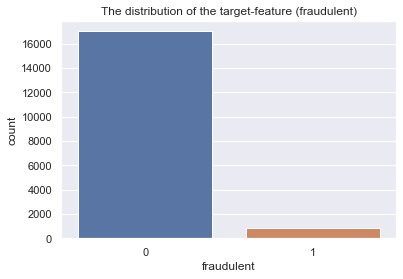

In [45]:
sns.countplot(data.fraudulent)
plt.title('The distribution of the target-feature (fraudulent)')
print(data.fraudulent.value_counts())

comment

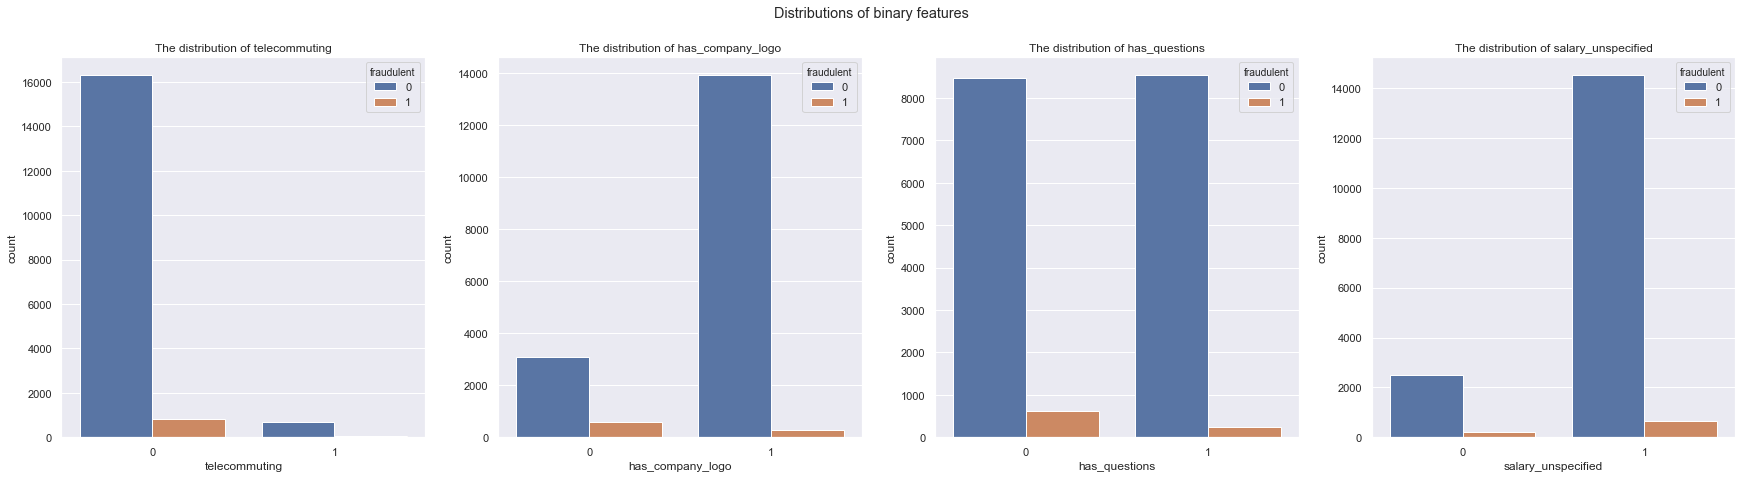

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(30, 7))

bin_features = ['telecommuting', 'has_company_logo', 'has_questions', 'salary_unspecified']
for ind, feature_name in enumerate(bin_features):
    sns.countplot(feature_name, hue='fraudulent', ax=axes[ind], data=data)
    axes[ind].set_title(f'The distribution of {feature_name}')
    
fig.suptitle('Distributions of binary features')
None

comment

In [47]:
for feature_name in bin_features:
    feature_values_of_0_fraudulent = data[data.fraudulent == 0][feature_name].values
    feature_values_of_1_fraudulent = data[data.fraudulent == 1][feature_name].values
    fv0f_count, fv0f_nobs = sum(feature_values_of_0_fraudulent), len(feature_values_of_0_fraudulent)
    fv1f_count, fv1f_nobs = sum(feature_values_of_1_fraudulent), len(feature_values_of_1_fraudulent)
    
    print(f'Feature: {feature_name}\n------')
    
    print(f'Proportion of {feature_name} for 0 fraudulent: {round(fv0f_count / fv0f_nobs, 4)}')
    print(f'Proportion of {feature_name} for 1 fraudulent: {round(fv1f_count / fv1f_nobs, 4)}')
    
    convint_0_frau = list(map(lambda lim: round(lim, 4), proportion_confint(fv0f_count, fv0f_nobs)))
    convint_1_frau = list(map(lambda lim: round(lim, 4), proportion_confint(fv1f_count, fv1f_nobs)))
    print(f'Сonfidence interval for 0 fraudulent: {convint_0_frau}')
    print(f'Сonfidence interval for 1 fraudulent: {convint_1_frau}')
    
    stat, p = proportions_ztest([fv0f_count, fv1f_count], [fv0f_nobs, fv1f_nobs])
    print(f'Z-test of {feature_name} proportions (p-value): {p}')
    
    print('------\n')

Feature: telecommuting
------
Proportion of telecommuting for 0 fraudulent: 0.0413
Proportion of telecommuting for 1 fraudulent: 0.0739
Сonfidence interval for 0 fraudulent: [0.0383, 0.0443]
Сonfidence interval for 1 fraudulent: [0.0565, 0.0913]
Z-test of telecommuting proportions (p-value): 3.907078901429856e-06
------

Feature: has_company_logo
------
Proportion of has_company_logo for 0 fraudulent: 0.8191
Proportion of has_company_logo for 1 fraudulent: 0.3268
Сonfidence interval for 0 fraudulent: [0.8134, 0.8249]
Сonfidence interval for 1 fraudulent: [0.2956, 0.358]
Z-test of has_company_logo proportions (p-value): 7.920579751525341e-269
------

Feature: has_questions
------
Proportion of has_questions for 0 fraudulent: 0.5021
Proportion of has_questions for 1 fraudulent: 0.2887
Сonfidence interval for 0 fraudulent: [0.4945, 0.5096]
Сonfidence interval for 1 fraudulent: [0.2585, 0.3189]
Z-test of has_questions proportions (p-value): 1.6381972531336588e-34
------

Feature: salary_un

comment

In [48]:
categorical_features = ['department', 'employment_type', 'required_experience', 
                        'required_education', 'industry', 'function', 'country', 
                        'state', 'city']
for feature_name in categorical_features:
    print(f'Count of {feature_name}\'s unique values: {data[feature_name].unique().shape[0]}')

Count of department's unique values: 1338
Count of employment_type's unique values: 6
Count of required_experience's unique values: 8
Count of required_education's unique values: 14
Count of industry's unique values: 132
Count of function's unique values: 38
Count of country's unique values: 91
Count of state's unique values: 325
Count of city's unique values: 2388


comment

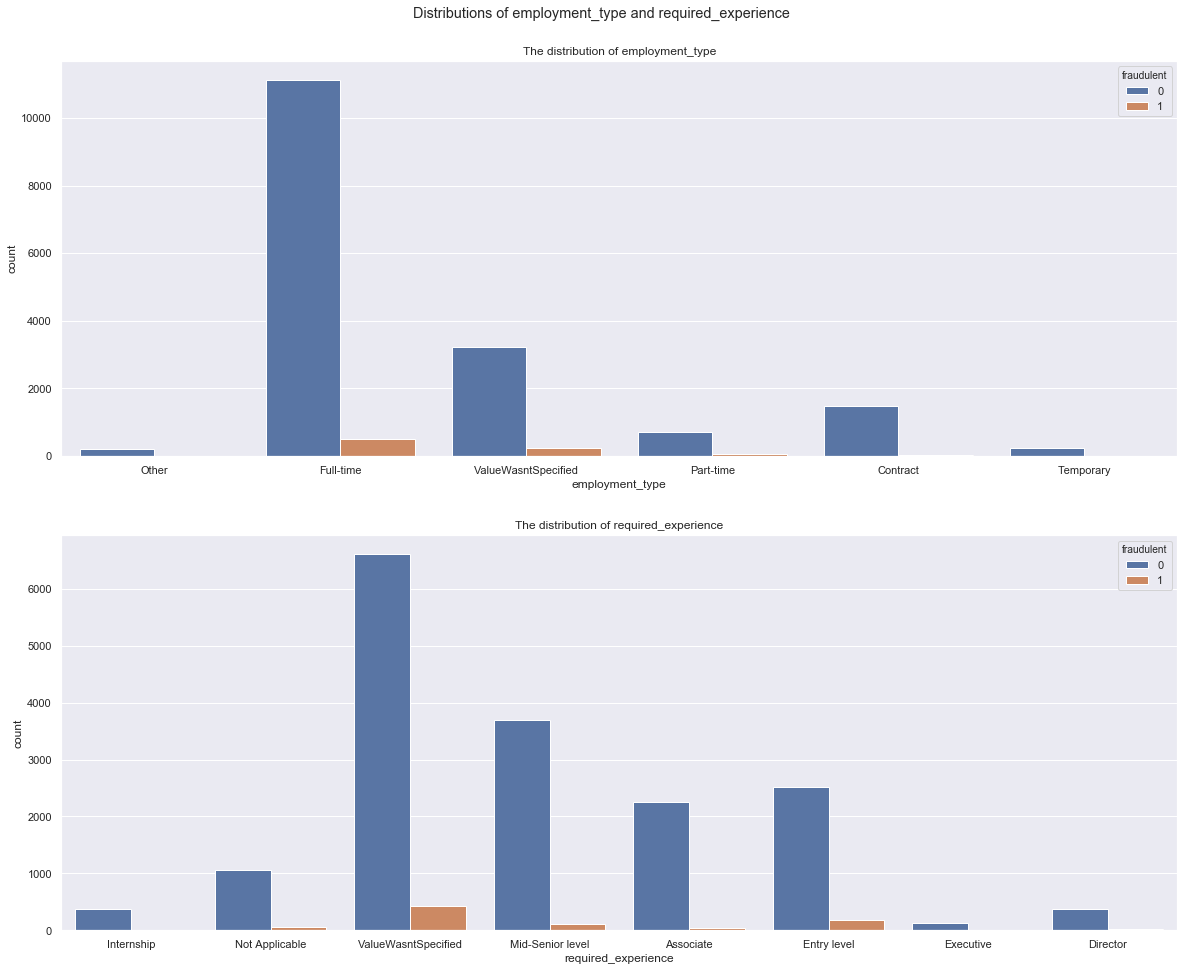

In [49]:
fig, axes = plt.subplots(2, figsize=(20, 15))

features_to_plot = ['employment_type', 'required_experience']
for ind, feature_name in enumerate(features_to_plot):
    sns.countplot(feature_name, hue='fraudulent', ax=axes[ind], data=data)
    axes[ind].set_title(f'The distribution of {feature_name}')
    
fig.suptitle('Distributions of employment_type and required_experience')
fig.subplots_adjust(top=0.93)
None

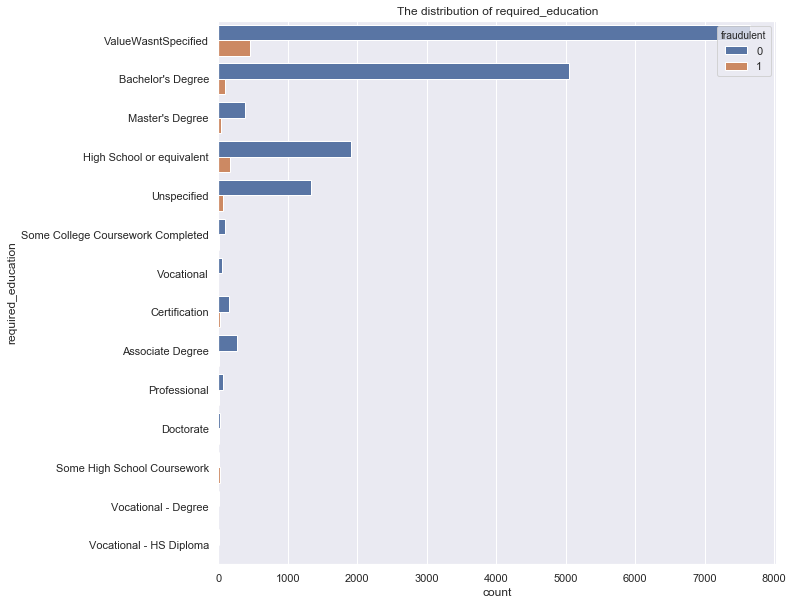

In [50]:
plt.figure(figsize=(10, 10))

sns.countplot(y='required_education', hue='fraudulent', orient='h', data=data)
plt.title(f'The distribution of required_education')
None

comment

In [56]:
for feature_name in categorical_features:
    feature_0_frau_vc = data[data.fraudulent == 0][feature_name].value_counts()
    feature_1_frau_vc = data[data.fraudulent == 1][feature_name].value_counts()
    
    feature_frau_info = pd.DataFrame({'fr0': feature_0_frau_vc, 
                                      'fr1': feature_1_frau_vc})
    feature_frau_info.fillna(0, inplace=True)
    feature_frau_info['total'] = feature_frau_info['fr0'] + feature_frau_info['fr1']
    feature_frau_info['prop1'] = feature_frau_info['fr1'] / feature_frau_info['total']
    
    prop_1_mean = feature_frau_info['prop1'].mean()
    expected_for_1 = round(feature_frau_info['total'] * prop_1_mean)
    
    stat, p = stats.chisquare(feature_frau_info['fr1'], expected_for_1, ddof=1)
    print(f'Chi-square test of {feature_name} for 1 fraudulent: {p}')

Chi-square test of department for 1 fraudulent: nan
Chi-square test of employment_type for 1 fraudulent: 5.975678297496309e-19
Chi-square test of required_experience for 1 fraudulent: 7.655839281151641e-25
Chi-square test of required_education for 1 fraudulent: 3.667839517708555e-126
Chi-square test of industry for 1 fraudulent: nan
Chi-square test of function for 1 fraudulent: 5.651904232239351e-127
Chi-square test of country for 1 fraudulent: nan
Chi-square test of state for 1 fraudulent: nan
Chi-square test of city for 1 fraudulent: nan


`stats.chisquare` returns nan with big numbers

comment

In [55]:
stats.chisquare?

comment

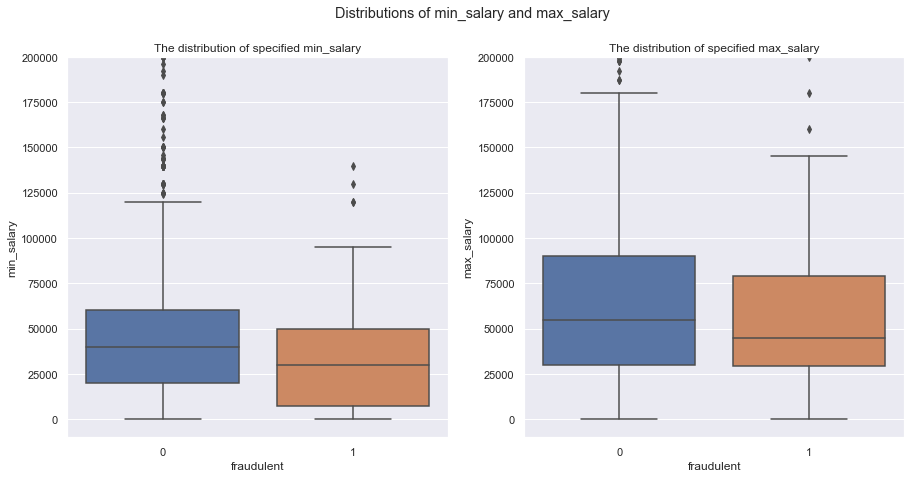

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

num_features = ['min_salary', 'max_salary']
for ind, feature_name in enumerate(num_features):
    sns.boxplot(y=feature_name, x='fraudulent', data=data[data.salary_unspecified == 0], ax=axes[ind])
    axes[ind].set_ylim([-1e4, 2e5])
    axes[ind].set_title(f'The distribution of specified {feature_name}')

fig.suptitle('Distributions of min_salary and max_salary')
None

comment

In [53]:
salary_means = data[data.salary_unspecified == 0][num_features].mean(axis=1)

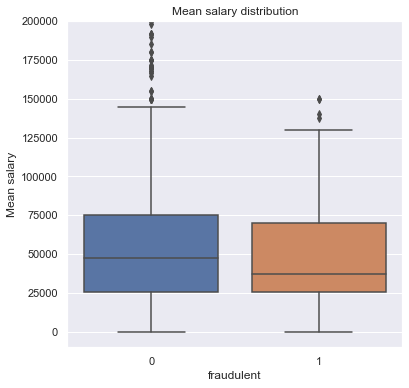

In [54]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=salary_means, x='fraudulent', data=data[data.salary_unspecified == 0])
plt.ylim([-1e4, 2e5])
plt.ylabel('Mean salary')
plt.title('Mean salary distribution')
None

comment

In [ ]:
# confints and hypotheses